In [9]:
%%writefile reachability.py
from safety import minInitCons, largest_fixpoint
from math import inf
class Reachability(minInitCons):
    """Compute energy needed to safely reach target set T with
    probability > 0.
    
    Expressed as largest fixpoint of a Bellman-style equation.
    The value of the action chooses a successor that we rely on
    for reaching the target and that has minimal value. The value
    of this successor is the energy needed to safely reach T via this
    successor + the safe energy level from the possibly-reached target
    state, or the energy needed to survive in some other successor
    under the action, whatever is higher.
    
    `targets` : `set of ints` target states
    """

    def __init__(self, mdp, targets, cap = inf):
        minInitCons.__init__(self, mdp, cap)

        self.targets = targets
        self.pos_reach_values = None
        self.alsure_values = None
        self.reach_safe_val = [inf] * self.states

    def reload_capper(self, s, v):
        """Reloads with value < capacity should be 0,
        anything above capacity should be ∞
        """
        # +1 handles cases when self.cap is ∞
        if v >= self.cap+1:
            return inf
        if self.is_reload(s):
            return 0
        return v

    def get_positiveReachability(self, recompute=False):
        """Return (and compute) minimal levels for positive
        reachability of `self.targets` and `self.capacity`.

        When called for the first time, compute the values.
        Recomputes the values if requested by `recompute`.

        A Bellman-style equation largest fixpoint solver.

        We start with ∞ for every state and propagate the safe energy
        needed to reach T from the target states further.
        """
        if not recompute and self.pos_reach_values is not None:
            return self.pos_reach_values

        self.get_safe_values(recompute)

        # Initialize:
        #  * safe_value for target states
        #  * inf otherwise
        self.pos_reach_values = [inf] * self.states

        for t in self.targets:
            self.pos_reach_values[t] = self.safe_values[t]

        largest_fixpoint(self.mdp, self.pos_reach_values,
                         self.action_value_T,
                         value_adj=self.reload_capper,
                         # Target states are always safe_values[t]
                         skip_state=lambda x: x in self.targets)
        return self.pos_reach_values

    def get_almostSureReachability(self, recompute=False):
        """Return (and compute) minimal levels for almost-sure
        reachability of `self.targets` and `self.capacity`.

        When called for the first time, compute the values.
        Recomputes the values if requested by `recompute`.

        A Bellman-style equation largest fixpoint solver.

        We start with ∞ for every state and propagate the safe energy
        needed to reach T from the target states further. After
        a fixpoint is reached, we remove the reload states that
        have the value equal to ∞ and proceed with another
        computation.

        The first iteration (the first fixpoint achieved) is equal
        to positive reachability.
        """
        if not recompute and self.alsure_values is not None:
            return self.alsure_values

        # removed stores reloads that had been removed from the MDP
        removed = set()

        done = False
        while not done:
            # Compute fixpoint without removed reloads

            # Initialize alsure_values:
            #  * safe_value for target states
            #  * inf otherwise
            self.alsure_values = [inf] * self.states
            for t in self.targets:
                self.alsure_values[t] = self.safe_values[t]

            # Recompute the "safe for reachability" values with removed reloads.
            # Store them in `reach_safe_val`.
            # The meaning is:
            #  1. survive without removed reloads, or
            #  2. reach a target state (from which I can use removed reloads again)
            #
            # Uses sufficient_levels computation initialized with removed and
            # start each iteration with:
            #  * self.safe_values[t] for targets (reach done, just survive) [2.]
            #  * ∞ for the rest                                             [1.]
            suff_l_init = lambda s: self.safe_values[s] if s in self.targets else inf
            self.sufficient_levels(removed, self.reach_safe_val, suff_l_init)

            # Mitigate reload removal
            rem_survival_val = lambda s: inf if s in removed else self.reach_safe_val[s]
            rem_action_value = lambda a, v: self.action_value_T(a, v, rem_survival_val)

            # Removed reloads are skipped
            is_removed = lambda x: x in removed # Improve performance only
            is_target  = lambda x: x in self.targets # Improve performance only
            # Over capacity values -> ∞

            largest_fixpoint(self.mdp, self.alsure_values,
                             rem_action_value,
                             value_adj=self.reload_capper,
                             skip_state=is_removed or is_target)

            done = True
            # Iterate over reloads and remove unusable ones (∞)
            for s in range(self.states):
                if self.is_reload(s) and self.alsure_values[s] == inf:
                    if s not in removed:
                        removed.add(s)
                        done = False

        return self.alsure_values

    def action_value_T(self, a, values, survival_val=None):
        """Compute value of action basd on curent values pf `r`

        `target_values` = List with values that applies for `r(t)` if `t`
                          satisfies `target_cond`. Equal to self.safe_values
                          if not given.
        `survival_val` = Function: `state` -> `value` interpreted as "what is
                         the level of energy I need to have in order to survive
                         if I reach `state`". Returns `self.safe_values[state]`
                         by default.
        """
        if survival_val is None:
            survival_val = lambda s: self.safe_values[s]

        # Initialization
        candidate = inf
        succs = a.distr.keys()

        for t in succs:
            survivals = [survival_val(s) for s in succs if s != t]
            current_v = values[t]
            t_v = max([current_v] + survivals)

            if t_v < candidate:
                candidate = t_v
            #print(f"{a.src} -- {a.label} -> {t}:{t_v}")
        return candidate + a.cons

Overwriting reachability.py


In [10]:
!python3 test.reachability.py

2


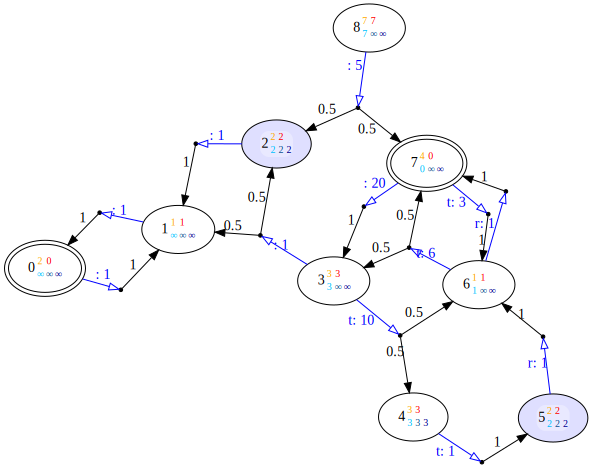

In [3]:
from reachability_examples import basic
m, targets = basic()

m.get_positiveReachability(targets, 20)
m.reachability.get_almostSureReachability()
m.show("R")

2


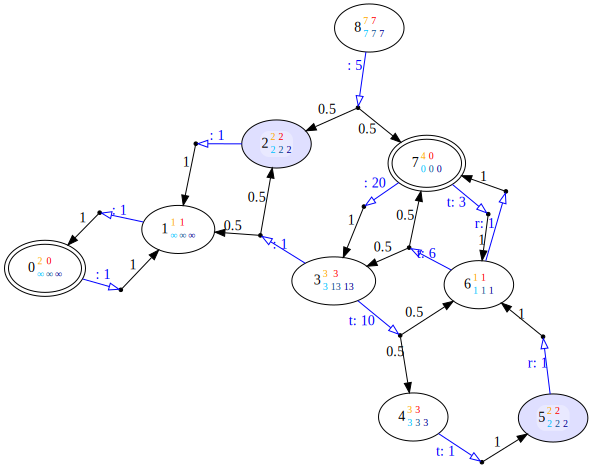

In [2]:
from reachability_examples import basic
m, targets = basic()

m.get_positiveReachability(targets, 40)
m.reachability.get_almostSureReachability()
m.show("R")

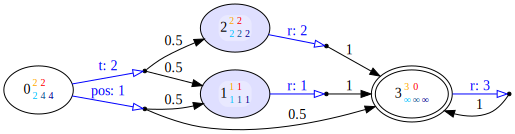

In [4]:
from reachability_examples import little_alsure

m, targets=little_alsure()

m.get_almostSureReachability(targets, 10)
m

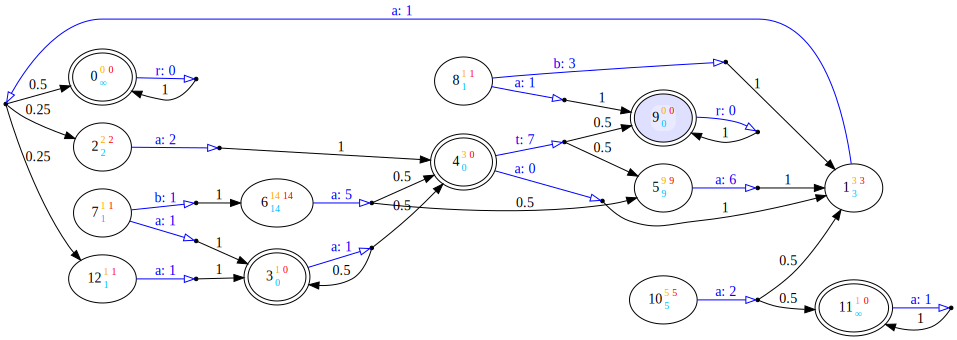

In [5]:
%run Kucera-example.ipynb
T = set([9])
targets = [True if s in T else False for s in range(m.num_states)]
m.add_action(4, {9:.5, 5:.5}, "t", 7)

m.get_positiveReachability(T, 16)
m

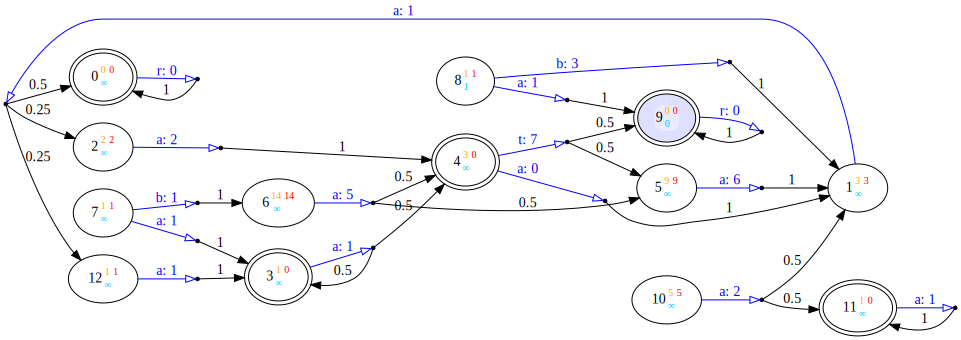

In [6]:
m.get_positiveReachability(T, 15)
m

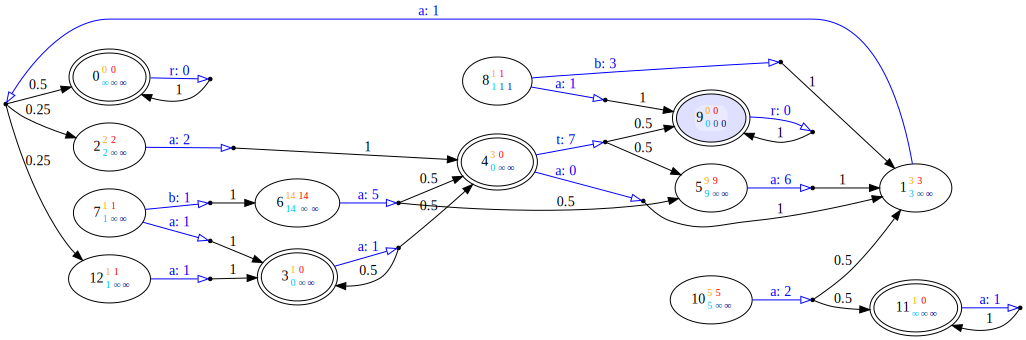

In [7]:
m.get_almostSureReachability(T, 16)
m